In [1]:
#CovidRFC.ipynb

#This notebook was made to predict the transmissions levels of SARS-CoV-2 in Suffolk County using an optimized
#Random Forest Classifier (RFC) model.

#Name of Programmer     #Date Modified     #Version

#Eram Kabir             #4/30/2022         #Version 0.6
#Eram Kabir             #6/17/2022         #Version 1.0

In [2]:
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib
import pandas as pd
from scipy.stats import spearmanr
import time

#Get Covid_data from API 

response = requests.get('https://api.covidactnow.org/v2/county/36103.timeseries.json?apiKey=50d010e98dc7431e93e7e344051215e5')

#Following line can be uncommented if json data is needed

#response2 = requests.get('https://api.covidactnow.org/v2/county/36103.json?apiKey=50d010e98dc7431e93e7e344051215e5')

#Check if data was loaded successfully (200 means success)

print(response.status_code)

200


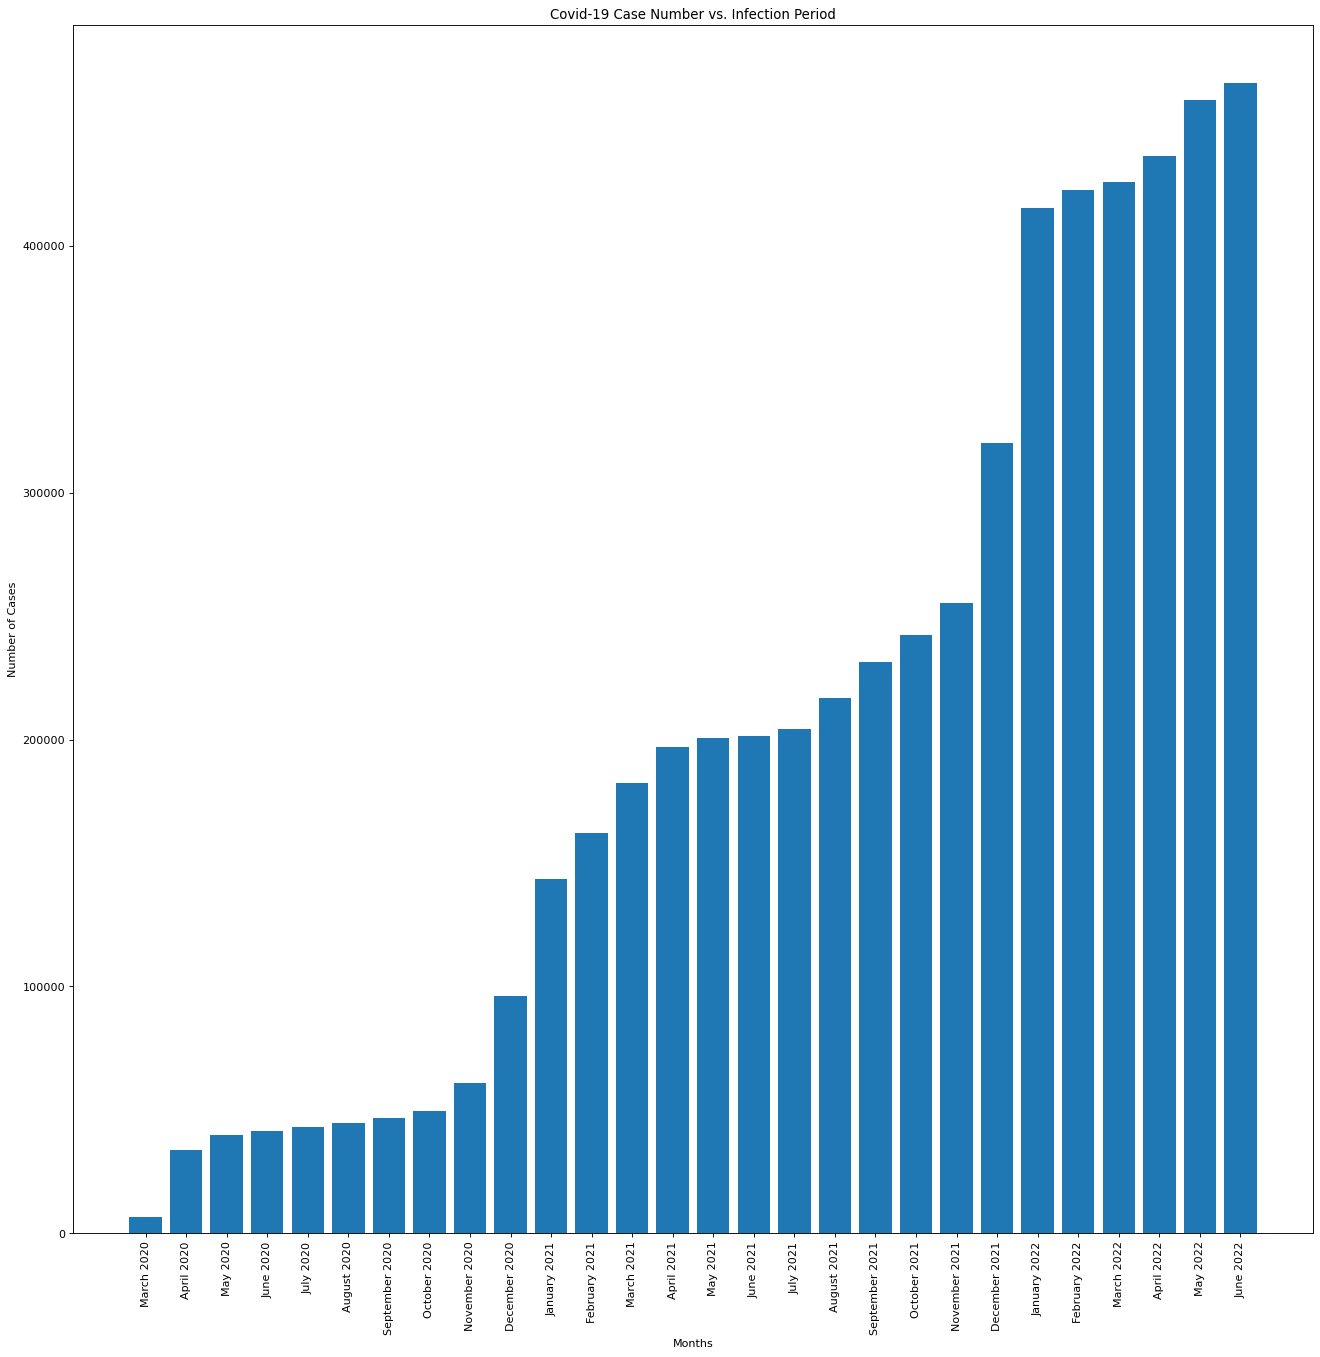

In [3]:
#Check amount of cases since start of pandemic

cases = [i.get('cases') for i in response.json()['actualsTimeseries']] #extract case numbers
dates = [i.get('date') for i in response.json()['actualsTimeseries']] #extract dates of case numbers

#fill in None values with 0
cases = [i if i!=None else 0 for i in cases]
dates = [i if i!=None else 0 for i in dates]

#Consolidate all dates into months
mb = 5 #month first number
me = 7 #month second number
yb = 0 #year first number
ye = 4 #year last number
counter = 0 #counter to keep track of dates

#for each date, transform it into month and year instead of YYYY-MM-DD based on values in it
for i in dates:
    if i[mb:me] == '01': #if month is 01
        dates[counter] = f'January {i[yb:ye]}' #transform YYYY-MM-DD into January and respective year
        counter+=1 #move on to next entry
    if i[mb:me] == '02':
        dates[counter] = f'February {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '03':
        dates[counter] = f'March {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '04':
        dates[counter] = f'April {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '05':
        dates[counter] = f'May {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '06':
        dates[counter] = f'June {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '07':
        dates[counter] = f'July {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '08':
        dates[counter] = f'August {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '09':
        dates[counter] = f'September {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '10':
        dates[counter] = f'October {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '11':
        dates[counter] = f'November {i[yb:ye]}'
        counter+=1
    if i[mb:me] == '12':
        dates[counter] = f'December {i[yb:ye]}'
        counter+=1
        
#plot results

figure(figsize=(20,20), dpi = 80) #enlarged figure

b = plt.bar(dates,cases) #plot cases with respect to dates

x = plt.xticks(rotation=90) #make the x values readable vertically

plt.title("Covid-19 Case Number vs. Infection Period") #title

plt.xlabel("Months") #x axis label

y = plt.ylabel("Number of Cases") #y axis label

#The transmission levels fluctuate, as seen in the graph. Predicting transmission levels can help to
#determine if lockdown should reoccur or be put on hold.

In [4]:
#Prediction of transmission levels part 1: Data cleaning/wrangling

covid_df = pd.DataFrame(response.json()['actualsTimeseries']) #load x data into DataFrame

#drop columns with no data and 'date' column from x data
covid_df = covid_df.drop(columns = ['hospitalBeds', 'hsaHospitalBeds', 
                                    'icuBeds', 'hsaIcuBeds', 'vaccinesAdministeredDemographics', 
                                    'vaccinationsInitiatedDemographics', 'vaccinesDistributed', 
                                    'vaccinesAdministered', 'positiveTests', 'negativeTests',
                                    'contactTracers', 'date'])

#load y data into Dataframe
covid_df_transmissions = pd.DataFrame(response.json()['cdcTransmissionLevelTimeseries'])

#drop date column from y data (the only relevant column to drop)
covid_df_transmissions = covid_df_transmissions.drop(columns = ['date'])

#calculate each feature's importance using spearman test
feature_importance, p = spearmanr(covid_df, covid_df_transmissions, axis=0, nan_policy='omit')

#p values were checked after the test was ran, and were accounted for in analysis

xy_correlator = len(covid_df.columns) #amount of features

#extract the last array, which is y data correlated with features, using xy_correlator
feature_importance = [i[xy_correlator] for i in feature_importance if i[xy_correlator]!=1]

#drop features with correlation < 0.5
covid_df = covid_df.drop(columns = covid_df.columns
                         [[feature_importance.index(feature_importance[i],i,len(feature_importance)) 
                           for i in range(0, len(feature_importance)) 
                           if feature_importance[i]<0.5]])

#fill NaN values with 0, since only few columns have them
covid_df = covid_df.fillna(0)

In [5]:
#Prediction of transmission levels part 2: Running the model(s)

y_array = [i[0] for i in covid_df_transmissions.values] #convert y data into a list

#split the data
X_train, X_test, y_train, y_test = train_test_split(covid_df, y_array, test_size=0.4, random_state=1)

#find optimal parameters for the machine learning model to be used (Random Forest Classifier [RCF])

#use GridSearchCV to run RCF models over selected parameters to find the best values

rfc_CV = GridSearchCV(RandomForestClassifier(), {'n_estimators':[50,100,150,200,250,300], 
                                                 'max_depth':[2,4,8,16,32,64], 
                                                 'max_leaf_nodes':[5,10,20,40,80,160]}, cv=5)

rfc_CV.fit(covid_df, y_array)

#extract the optimized parameters to the true RCF model
tuned_parameters = rfc_CV.best_params_

RFC_Covid_Optimized = RandomForestClassifier(n_estimators=tuned_parameters['n_estimators'], 
                                             max_depth=tuned_parameters['max_depth'], 
                                             max_leaf_nodes=tuned_parameters['max_leaf_nodes'])

RFC_Covid_Optimized = RFC_Covid_Optimized.fit(X_train, y_train)

y_pred = RFC_Covid_Optimized.predict(X_test) #run the model

result = accuracy_score(y_test,y_pred) #calculate accuracy of model

print("Accuracy:",result) #print accuracy

#confusion matrix showing True and False Positives and Negatives
confusion_matrix_RFC = confusion_matrix(y_test,y_pred)

print(confusion_matrix_RFC) #print confusion matrix

#confusion matrix parameters
classification_report_RFC = classification_report(y_test,y_pred, labels=np.unique(y_pred))

print(classification_report_RFC) #print confusion matrix parameters

Accuracy: 0.9017857142857143
[[  0   0   0   3]
 [  0  81   6   2]
 [  0  10  20   6]
 [  0   4   2 202]]
              precision    recall  f1-score   support

           1       0.85      0.91      0.88        89
           2       0.71      0.56      0.63        36
           3       0.95      0.97      0.96       208

   micro avg       0.90      0.91      0.91       333
   macro avg       0.84      0.81      0.82       333
weighted avg       0.90      0.91      0.90       333



In [6]:
#Prediction of transmission levels part 3: Saving the model(s) for deployment

joblib.dump(RFC_Covid_Optimized, 'CovidRFCmodel.pkl', compress=1)

['CovidRFCmodel.pkl']